# **Bangkit Final Project: World Coin Classification**

# **Dependencies**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile

from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import Regularizer, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from google.colab import files, drive

In [2]:
# Upload the kaggle.json file from Kaggle account settings page
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
# Install the Kaggle API client
!pip install -q kaggle

In [4]:
# The Kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

# **Importing Dataset**

In [5]:
# Download the dataset
!kaggle datasets download -d wanderdust/coin-images

 99% 454M/459M [00:07<00:00, 62.0MB/s]
100% 459M/459M [00:07<00:00, 60.5MB/s]


In [6]:
# If kaggle is down, mount from drive
try:
    coin_file = open('/content/coin-images.zip', 'r')
    filepath = '/content/coin-images.zip'
except FileNotFoundError:
    # Keep preset values
    drive.mount('/content/drive')
    filepath = '/content/drive/My Drive/Bangkit project/Dataset/coin-images.zip'

# Unzip the dataset into folder
zip_ref = zipfile.ZipFile(filepath, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

# **Data Preparation**

In [7]:
# Define directories
data_dir = "/content/coins/data/"

train_dir = data_dir + "train/"
validation_dir = data_dir + "validation/"
test_dir = data_dir + "test/"

In [8]:
# Create generators
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=360,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      brightness_range=[0.8,1.2],
      horizontal_flip=False,
      vertical_flip=False,
      featurewise_std_normalization=False,
      featurewise_center=False,
      samplewise_std_normalization=False,
      samplewise_center=False,
      fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=360,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      brightness_range=[0.8,1.2],
      horizontal_flip=False,
      vertical_flip=False,
      featurewise_std_normalization=False,
      featurewise_center=False,
      samplewise_std_normalization=False,
      samplewise_center=False,
      fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
      rescale=1./255,
      featurewise_std_normalization=False,
      featurewise_center=False,
      samplewise_std_normalization=False,
      samplewise_center=False
)

In [9]:
# Read images from generators
batch_size = 32
image_width = 299
image_height = 299

train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=batch_size
)

validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=batch_size
)

test_generator = test_datagen.flow_from_directory(
      test_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=1
)

Found 6413 images belonging to 211 classes.
Found 844 images belonging to 211 classes.
Found 844 images belonging to 211 classes.


# **Model**

In [22]:
# Load base model
base_model = InceptionV3(input_shape=(image_width, image_height, 3), weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = True

    # Add regularizer
    l2_layer = l2(0.01)
    if hasattr(layer, 'kernel'):
        base_model.add_loss(lambda layer=layer: l2_layer(layer.kernel))

for layer in base_model.layers[:10]:
		layer.trainable = False

# Custom top classifier for model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(211, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [23]:
# Callback to reduce learning rate if no improvement in validation loss for certain number of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8, verbose=1)

# Callback to stop training if no improvement in validation loss for certain number of epochs
early_stop = EarlyStopping(monitor='val_loss', patience=20)

# Callback to save best model weights per epoch
weights_filepath = "best_model_weights.hdf5"
checkpoint = ModelCheckpoint(
    filepath=weights_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=0.0001), metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=80,
    steps_per_epoch=50,
    validation_data=validation_generator,
    verbose=1,
    validation_steps=3,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/80
50/50 [==============================] - ETA: 0s - loss: 5.3361 - accuracy: 0.0200
Epoch 00001: val_accuracy improved from -inf to 0.02083, saving model to best_model_weights.hdf5
50/50 [==============================] - 49s 979ms/step - loss: 5.3361 - accuracy: 0.0200 - val_loss: 5.3155 - val_accuracy: 0.0208 - lr: 1.0000e-04
Epoch 2/80
50/50 [==============================] - ETA: 0s - loss: 4.9635 - accuracy: 0.0794
Epoch 00002: val_accuracy improved from 0.02083 to 0.11458, saving model to best_model_weights.hdf5
50/50 [==============================] - 48s 959ms/step - loss: 4.9635 - accuracy: 0.0794 - val_loss: 4.8224 - val_accuracy: 0.1146 - lr: 1.0000e-04
Epoch 3/80
50/50 [==============================] - ETA: 0s - loss: 4.3715 - accuracy: 0.1800
Epoch 00003: val_accuracy improved from 0.11458 to 0.16667, saving model to best_model_weights.hdf5
50/50 [==============================] - 48s 964ms/step - loss: 4.3715 - accuracy: 0.1800 - val_loss: 4.3390 - val_accuracy

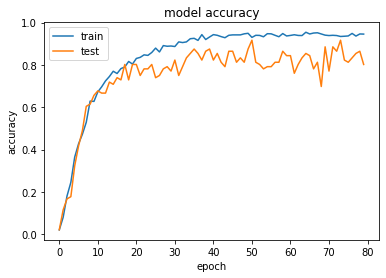

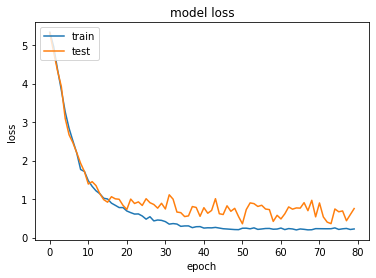

In [24]:
# Visualise accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualise loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# Save model
model.save("inception_model.h5")

In [26]:
# Evaluate model
train_score = model.evaluate(train_generator, verbose=1)
print("Training loss: ", train_score[0])
print("Training accuracy: ", train_score[1])

validation_score = model.evaluate(validation_generator, verbose=1)
print("Validation loss: ", validation_score[0])
print("Validation accuracy: ", validation_score[1])

test_score = model.evaluate(test_generator, verbose=1)
print("Testing loss: ", test_score[0])
print("Testing accuracy: ", test_score[1])

201/201 [==============================] - 159s 791ms/step - loss: 0.0959 - accuracy: 0.9704
Training loss:  0.09589181840419769
Training accuracy:  0.9703726768493652
27/27 [==============================] - 20s 754ms/step - loss: 0.6597 - accuracy: 0.8341
Validation loss:  0.6597456932067871
Validation accuracy:  0.8341231942176819
844/844 [==============================] - 15s 17ms/step - loss: 0.6086 - accuracy: 0.8566
Testing loss:  0.6086258292198181
Testing accuracy:  0.8566350936889648


In [27]:
model_best_weights = model

# Load best model weights
model_best_weights.load_weights(weights_filepath)

# Save model
model_best_weights.save("inception_model_best_weights.h5")

In [28]:
# Evaluate model
train_score = model_best_weights.evaluate(train_generator, verbose=1)
print("Training loss: ", train_score[0])
print("Training accuracy: ", train_score[1])

validation_score = model_best_weights.evaluate(validation_generator, verbose=1)
print("Validation loss: ", validation_score[0])
print("Validation accuracy: ", validation_score[1])

test_score = model_best_weights.evaluate(test_generator, verbose=1)
print("Testing loss: ", test_score[0])
print("Testing accuracy: ", test_score[1])

201/201 [==============================] - 158s 785ms/step - loss: 0.1019 - accuracy: 0.9705
Training loss:  0.10186693072319031
Training accuracy:  0.9705286026000977
27/27 [==============================] - 20s 744ms/step - loss: 0.6898 - accuracy: 0.8329
Validation loss:  0.6897547841072083
Validation accuracy:  0.8329383730888367
844/844 [==============================] - 14s 17ms/step - loss: 0.6142 - accuracy: 0.8566
Testing loss:  0.6141502261161804
Testing accuracy:  0.8566350936889648


In [29]:
# Predict test images
predictions = []

for filename in test_generator.filenames:
    img = load_img(test_dir+filename, target_size=(image_width, image_height))
    img = img_to_array(img)/255
    img_expand = np.expand_dims(img, axis=0)
    predictions.append(model.predict(img_expand)[0])

In [30]:
# Get index of largest probability
predicted_indices = np.argmax(predictions, axis=1)

# Get coin directory name from index 
directories = dict((v, k) for k, v in train_generator.class_indices.items())
predicted_dir = [directories.get(k) for k in predicted_indices]

# Get label name from coin directory name
with open(data_dir + 'cat_to_name.json', 'r') as json_file:
    labels = json.load(json_file)
predicted_labels = [labels.get(str(k)) for k in predicted_dir]

In [31]:
# Save predicted labels as CSV file
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames, "Predictions": predicted_labels})
results.to_csv("inception_results.csv", index=False)
results.head()

,Filename,Predictions
0,1/021__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
1,1/022__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
2,1/027__1 Cent_australia.jpg,"2 Cents,Australian dollar,australia"
3,1/036__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
4,10/005__5 Centavos_brazil.jpg,"5 Centavos,Brazilian Real,brazil"


# **Convert to TFLite**

In [32]:
# Create converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()
open("inception_model.tflite", "wb").write(tflite_model)

23018208

# **Copy model to Drive**

In [33]:
drive.mount('/content/drive')
!cp inception_model.h5 "/content/drive/My Drive/Bangkit project/models"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
